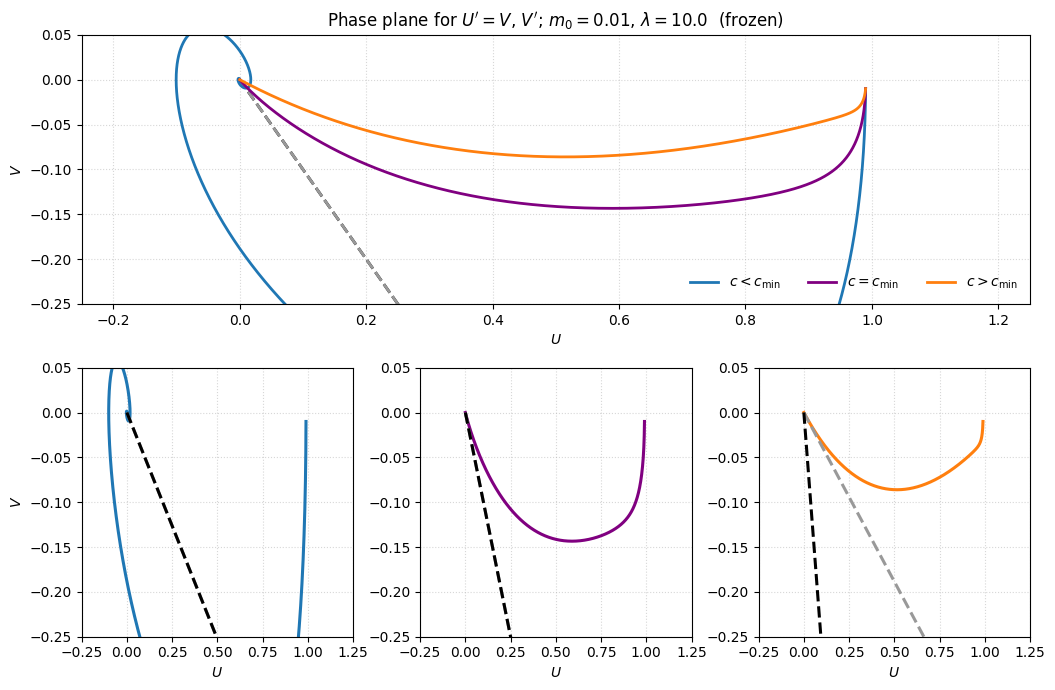

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# -----------------------------
# Choose mode: "frozen" (spiral) or "coupled" (full 3D projection)
# -----------------------------
MODE = "frozen"   # <- set to "coupled" to see the non-spiral projection

# -----------------------------
# Parameters
# -----------------------------
lam  = 10.0
m0   = 0.01
U0, V0, M0 = .99, -0.01, m0

# c values used in the paper
c_list  = [1.0, 2.0*(1.0 - m0), 3.0]     # {c < c_min, c = c_min, c > c_min}
labels  = [r"$c<c_{\min}$", r"$c=c_{\min}$", r"$c>c_{\min}$"]
colors  = ["tab:blue", "purple", "tab:orange"]

# plotting windows (apply to all axes)
U_lim = (-0.25, 1.25)
V_lim = (-0.25, 0.05)

# integration output (paper: τ = 0.01, final t = 100)
T_end  = 1000.0
dt     = 0.001
t_eval = np.arange(0.0, T_end + dt, dt)

# -----------------------------
# RHS: full (U,V,M) system
# -----------------------------
def rhs_3d(z, y, c):
    U, V, M = y
    M = np.clip(M, -5.0, 1.0 - 1e-9)
    dU = V
    dV = (1.0/(1.0 - M)) * (
            -c*V
            - (lam/c)*M*U*V
            - (lam**2 / c**2)*M*U**3
            - U*(1.0 - U - M)
         )
    dM = (lam/c)*M*U
    return [dU, dV, dM]

# -----------------------------
# RHS: planar (U,V) with M frozen at m0  -> this produces the spiral
# -----------------------------
def rhs_2d(z, y, c):
    U, V = y
    M = m0
    dU = V
    dV = (1.0/(1.0 - M)) * (
            -c*V
            - (lam/c)*M*U*V
            - (lam**2 / c**2)*M*U**3
            - U*(1.0 - U - M)
         )
    return [dU, dV]

# -----------------------------
# Linearisation slopes at (0,0) for M = m0 (for eigenvector lines)
# A = [[0,1],[-1, -c/(1-m0)]]; slopes are roots of l^2 + (c/(1-m0)) l + 1 = 0
# -----------------------------
def eig_slopes(c):
    a = c/(1.0 - m0)
    disc = a*a - 4.0
    if disc >= 0:
        l1 = 0.5*(-a + np.sqrt(disc))
        l2 = 0.5*(-a - np.sqrt(disc))
    else:
        l1 = l2 = -0.5*a        # real part for guidance in spiral case
    return float(l1), float(l2)

# -----------------------------
# Figure layout (top + 3 bottoms)
# -----------------------------
fig = plt.figure(figsize=(10.5, 7.0))
ax_top = plt.subplot2grid((2,3), (0,0), colspan=3)
axes   = [plt.subplot2grid((2,3), (1,i)) for i in range(3)]

# Draw eigenvectors once (for c=c_min) in top panel
c_mid = c_list[1]
l1_mid, l2_mid = eig_slopes(c_mid)
U_eig = np.array([0.0, 1.0])
ax_top.plot(U_eig, l1_mid*U_eig, ls='--', lw=2.0, color='k')
ax_top.plot(U_eig, l2_mid*U_eig, ls='--', lw=2.0, color='0.6')

for ax in [ax_top] + axes:
    ax.set_xlim(U_lim); ax.set_ylim(V_lim)
    ax.grid(True, ls=":", alpha=0.5)

# Integrate each case
for i, (c, lab, col) in enumerate(zip(c_list, labels, colors)):
    if MODE == "frozen":
        # planar integration with M ≡ m0  (spiral for c < c_min)
        sol = solve_ivp(rhs_2d, (0.0, T_end), [U0, V0],
                        args=(c,), t_eval=t_eval, rtol=1e-10, atol=1e-12, max_step=0.05)
        U, V = sol.y[0], sol.y[1]
    else:
        # full 3D, projected to (U,V)  (typically no spiral)
        sol = solve_ivp(rhs_3d, (0.0, T_end), [U0, V0, M0],
                        args=(c,), t_eval=t_eval, rtol=1e-10, atol=1e-12, max_step=0.05)
        U, V = sol.y[0], sol.y[1]

    # Top: overlay trajectories
    ax_top.plot(U, V, color=col, lw=2.0, label=lab)

    # Bottom per-case + its eigenvectors
    ax = axes[i]
    ax.plot(U, V, color=col, lw=2.2)
    l1, l2 = eig_slopes(c)
    ax.plot(U_eig, l1*U_eig, ls='--', lw=2.2, color='0.6')  # v2 (grey)
    ax.plot(U_eig, l2*U_eig, ls='--', lw=2.2, color='k')    # w3 (black)
    ax.set_xlabel(r"$U$")
    if i == 0:
        ax.set_ylabel(r"$V$")

# Cosmetics for top
ax_top.set_xlabel(r"$U$")
ax_top.set_ylabel(r"$V$")
ax_top.set_title(r"Phase plane for $U'=V$, $V'$; $m_0={:.2g}$, $\lambda={}$  ({})"
                 .format(m0, lam, MODE))
ax_top.legend(frameon=False, ncol=3, loc="lower right")

plt.tight_layout()
plt.show()

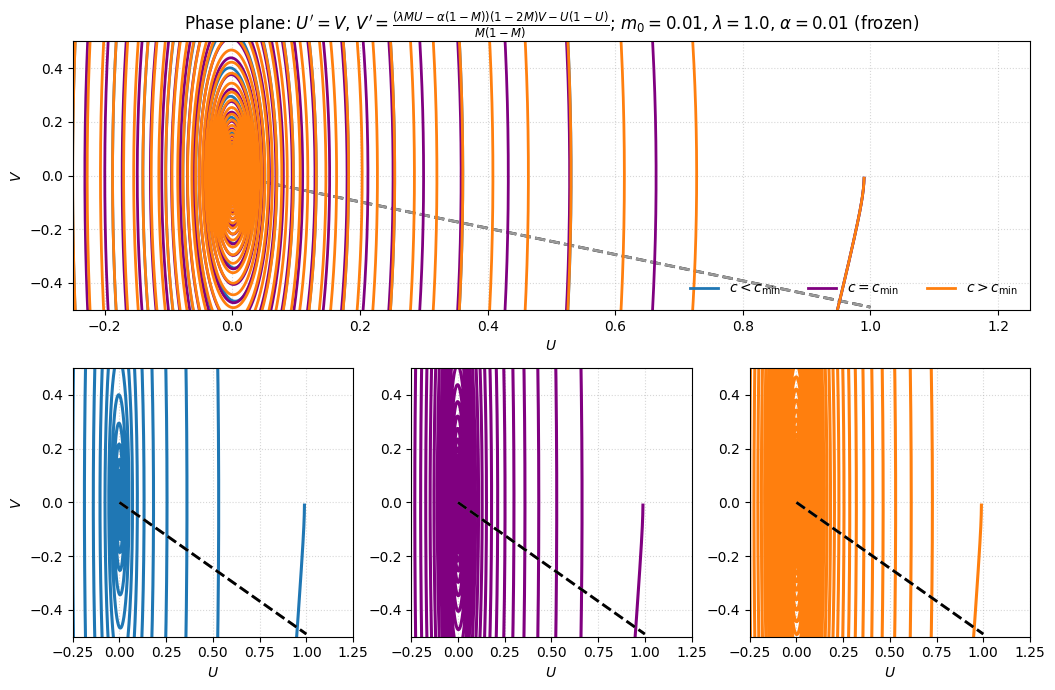

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

MODE = "frozen"   # or "coupled"

# Parameters
lam   = 1.0
alpha = 0.01
m0    = 0.01
U0, V0, M0 = 0.99, -0.01, m0

# c sweep
c_list  = [1.0, 2.0*(1.0 - m0), 3.0]
labels  = [r"$c<c_{\min}$", r"$c=c_{\min}$", r"$c>c_{\min}$"]
colors  = ["tab:blue", "purple", "tab:orange"]

# Plot windows
U_lim = (-0.25, 1.25)
V_lim = (-0.5, 0.5)

# Integration grid
T_end  = 1000.0
dt     = 0.001
t_eval = np.arange(0.0, T_end + dt, dt)

EPS = 1e-9  # to avoid division by zero at M=0 or 1

# ---------- RHS: full (U,V,M) ----------
def rhs_3d(z, y, c):
    U, V, M = y
    M = np.clip(M, EPS, 1.0 - EPS)
    dU = V
    num = (lam*M*U - alpha*(1.0 - M)) * (1.0 - 2.0*M) * V - U*(1.0 - U)
    dV = num / (M * (1.0 - M))
    dM = (lam*M*U - alpha*(1.0 - M)) / c
    return [dU, dV, dM]

# ---------- RHS: planar (U,V) with M frozen = m0 ----------
def rhs_2d(z, y, c):
    U, V = y
    M = np.clip(m0, EPS, 1.0 - EPS)
    dU = V
    num = (lam*M*U - alpha*(1.0 - M))/c * (1.0 - 2.0*M) * V - U*(1.0 - U)
    dV = num / (M * (1.0 - M))
    return [dU, dV]

# ---------- Linearised eigen-slopes at (U,V)=(0,0), M=m0 ----------
# U' = V,  V' ≈ a V - k U  with a = -alpha*(1-2 m0)/m0, k = 1/(m0(1-m0))
def eig_slopes_for_m0(alpha, m0):
    k = 1.0 / (m0 * (1.0 - m0))
    a = -alpha * (1.0 - 2.0*m0) / m0
    disc = a*a - 4.0*k
    if disc >= 0:
        l1 = 0.5*(a + np.sqrt(disc))
        l2 = 0.5*(a - np.sqrt(disc))
    else:
        l1 = l2 = 0.5*a  # real part for guidance if complex
    return float(l1), float(l2)

# ---------- Figure ----------
fig = plt.figure(figsize=(10.5, 7.0))
ax_top = plt.subplot2grid((2,3), (0,0), colspan=3)
axes   = [plt.subplot2grid((2,3), (1,i)) for i in range(3)]

# Eigenline guides (independent of c)
l1_mid, l2_mid = eig_slopes_for_m0(alpha, m0)
U_eig = np.array([0.0, 1.0])
ax_top.plot(U_eig, l1_mid*U_eig, ls='--', lw=2.0, color='k')
ax_top.plot(U_eig, l2_mid*U_eig, ls='--', lw=2.0, color='0.6')

for ax in [ax_top] + axes:
    ax.set_xlim(U_lim); ax.set_ylim(V_lim)
    ax.grid(True, ls=":", alpha=0.5)

# ---------- Integrate & plot ----------
for i, (c, lab, col) in enumerate(zip(c_list, labels, colors)):
    if MODE == "frozen":
        sol = solve_ivp(rhs_2d, (0.0, T_end), [U0, V0],
                        args=(c,), t_eval=t_eval, rtol=1e-10, atol=1e-12, max_step=0.05)
        U, V = sol.y[0], sol.y[1]
    else:
        sol = solve_ivp(rhs_3d, (0.0, T_end), [U0, V0, M0],
                        args=(c,), t_eval=t_eval, rtol=1e-10, atol=1e-12, max_step=0.05)
        U, V = sol.y[0], sol.y[1]

    ax_top.plot(U, V, color=col, lw=2.0, label=lab)

    ax = axes[i]
    ax.plot(U, V, color=col, lw=2.2)
    ax.plot(U_eig, l1_mid*U_eig, ls='--', lw=2.0, color='0.6')
    ax.plot(U_eig, l2_mid*U_eig, ls='--', lw=2.0, color='k')
    ax.set_xlabel(r"$U$")
    if i == 0:
        ax.set_ylabel(r"$V$")

ax_top.set_xlabel(r"$U$")
ax_top.set_ylabel(r"$V$")
ax_top.set_title(
    r"Phase plane: $U'=V$, $V'=\frac{(\lambda MU-\alpha(1-M))(1-2M)V-U(1-U)}{M(1-M)}$; "
    + r"$m_0={:.2g}$, $\lambda={}$, $\alpha={}$ ({})".format(m0, lam, alpha, MODE)
)
ax_top.legend(frameon=False, ncol=3, loc="lower right")

plt.tight_layout()
plt.show()

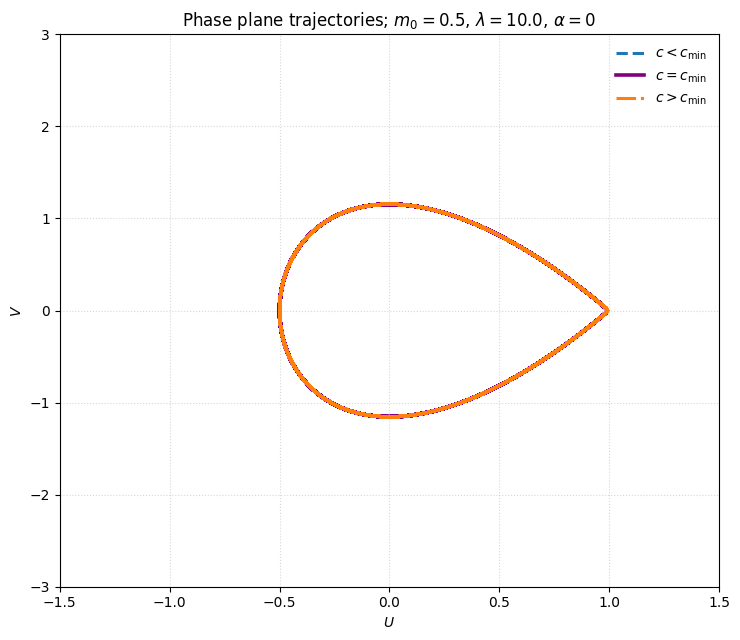

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# -----------------------------
# Parameters
# -----------------------------
lam   = 10.0
alpha = 0
m0    = 0.5
U0, V0, M0 = 0.99, -0.01, m0

# c_min for your alpha=0 case (as you set it)
c_min = 2.0 * np.sqrt (m0 * (1.0 - m0))
c_list  = [0.01, c_min, 100]
labels  = [r"$c<c_{\min}$", r"$c=c_{\min}$", r"$c>c_{\min}$"]
colors  = ["tab:blue", "purple", "tab:orange"]  # color by case

# ---- ZOOM window (change here) ----
U_xlim = (-1.5, 1.5)   # wider U-range
V_ylim = (-3.0, 3.0)   # wider V-range
# -----------------------------------

# integration grid
T_end  = 1000.0
dt     = 0.001
t_eval = np.arange(0.0, T_end + dt, dt)
EPS    = 1e-9

# ---------- RHS: planar (U,V) with M frozen = m0 ----------
def rhs_2d(z, y, c):
    U, V = y
    M = np.clip(m0, EPS, 1.0 - EPS)
    dU = V
    num = (lam*M*U - alpha*(1.0 - M))/c * (1.0 - 2.0*M) * V - U*(1.0 - U)
    dV = num / (M * (1.0 - M))
    return [dU, dV]

# ---------- Eigenline slopes at (U,V)=(0,0), M=m0 ----------
def eig_slopes_for_m0(alpha, m0):
    k = 1.0 / (m0 * (1.0 - m0))
    a = -alpha * (1.0 - 2.0*m0) / m0
    disc = a*a - 4.0*k
    if disc >= 0:
        l1 = 0.5*(a + np.sqrt(disc))
        l2 = 0.5*(a - np.sqrt(disc))
        return float(l1), float(l2)
    else:
        return None, None  # complex -> skip plotting real slope lines

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(7.5,6.5))

# draw eigenline guidance if real
l1, l2 = eig_slopes_for_m0(alpha, m0)
U_eig = np.array([0.0, 1.0])
if l1 is not None:
    ax.plot(U_eig, l1*U_eig, ls='--', lw=2.0, color='k', alpha=0.6, label="eig. dir.")
    ax.plot(U_eig, l2*U_eig, ls='--', lw=2.0, color='0.6', alpha=0.6)

# style map by relation to c_min
def style_for(c):
    if np.isclose(c, c_min, rtol=1e-9, atol=1e-12):
        return dict(ls='-', lw=2.6)         # middle/borderline
    elif c < c_min:
        return dict(ls='--', lw=2.2)        # c < c_min
    else:
        return dict(ls='-.', lw=2.2)        # c > c_min

# integrate & overlay trajectories
for c, lab, col in zip(c_list, labels, colors):
    sol = solve_ivp(rhs_2d, (0.0, T_end), [U0, V0],
                    args=(c,), t_eval=t_eval, rtol=1e-10, atol=1e-12, max_step=0.05)
    U, V = sol.y[0], sol.y[1]
    ax.plot(U, V, color=col, label=lab, **style_for(c))

# zoomed limits
ax.set_xlim(*U_xlim)
ax.set_ylim(*V_ylim)

ax.set_xlabel(r"$U$")
ax.set_ylabel(r"$V$")
ax.set_title(r"Phase plane trajectories; $m_0={:.2g}$, $\lambda={}$, $\alpha={}$"
             .format(m0, lam, alpha))
ax.legend(frameon=False, loc="best")
ax.grid(True, ls=":", alpha=0.5)

plt.tight_layout()
plt.show()

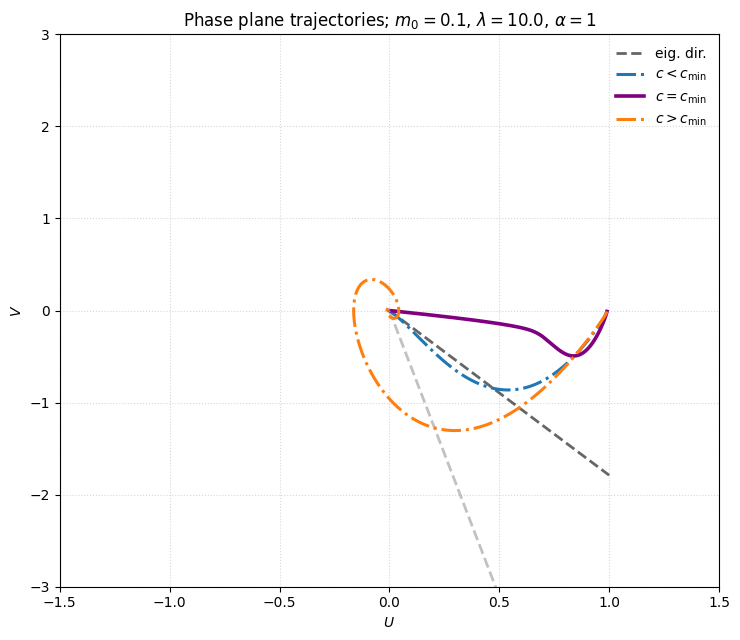

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# -----------------------------
# Parameters
# -----------------------------
lam   = 10.0
alpha = 1
m0    = 0.1
U0, V0, M0 = 0.99, -0.01, m0

# c_min for your alpha=0 case (as you set it)
c_min = 2.0 * m0 * (1.0 - m0)
c_list  = [1.0, c_min, 3.0]
labels  = [r"$c<c_{\min}$", r"$c=c_{\min}$", r"$c>c_{\min}$"]
colors  = ["tab:blue", "purple", "tab:orange"]  # color by case

# ---- ZOOM window (change here) ----
U_xlim = (-1.5, 1.5)   # wider U-range
V_ylim = (-3.0, 3.0)   # wider V-range
# -----------------------------------

# integration grid
T_end  = 1000.0
dt     = 0.001
t_eval = np.arange(0.0, T_end + dt, dt)
EPS    = 1e-9

# ---------- RHS: planar (U,V) with M frozen = m0 ----------
def rhs_2d(z, y, c):
    U, V = y
    M = np.clip(m0, EPS, 1.0 - EPS)
    dU = V
    num = (lam*M*U - alpha*(1.0 - M))/c * (1.0 - 2.0*M) * V - U*(1.0 - U)
    dV = num / (M * (1.0 - M))
    return [dU, dV]

# ---------- Eigenline slopes at (U,V)=(0,0), M=m0 ----------
def eig_slopes_for_m0(alpha, m0):
    k = 1.0 / (m0 * (1.0 - m0))
    a = -alpha * (1.0 - 2.0*m0) / m0
    disc = a*a - 4.0*k
    if disc >= 0:
        l1 = 0.5*(a + np.sqrt(disc))
        l2 = 0.5*(a - np.sqrt(disc))
        return float(l1), float(l2)
    else:
        return None, None  # complex -> skip plotting real slope lines

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(7.5,6.5))

# draw eigenline guidance if real
l1, l2 = eig_slopes_for_m0(alpha, m0)
U_eig = np.array([0.0, 1.0])
if l1 is not None:
    ax.plot(U_eig, l1*U_eig, ls='--', lw=2.0, color='k', alpha=0.6, label="eig. dir.")
    ax.plot(U_eig, l2*U_eig, ls='--', lw=2.0, color='0.6', alpha=0.6)

# style map by relation to c_min
def style_for(c):
    if np.isclose(c, c_min, rtol=1e-9, atol=1e-12):
        return dict(ls='-', lw=2.6)         # middle/borderline
    elif c < c_min:
        return dict(ls='--', lw=2.2)        # c < c_min
    else:
        return dict(ls='-.', lw=2.2)        # c > c_min

# integrate & overlay trajectories
for c, lab, col in zip(c_list, labels, colors):
    sol = solve_ivp(rhs_2d, (0.0, T_end), [U0, V0],
                    args=(c,), t_eval=t_eval, rtol=1e-10, atol=1e-12, max_step=0.05)
    U, V = sol.y[0], sol.y[1]
    ax.plot(U, V, color=col, label=lab, **style_for(c))

# zoomed limits
ax.set_xlim(*U_xlim)
ax.set_ylim(*V_ylim)

ax.set_xlabel(r"$U$")
ax.set_ylabel(r"$V$")
ax.set_title(r"Phase plane trajectories; $m_0={:.2g}$, $\lambda={}$, $\alpha={}$"
             .format(m0, lam, alpha))
ax.legend(frameon=False, loc="best")
ax.grid(True, ls=":", alpha=0.5)

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

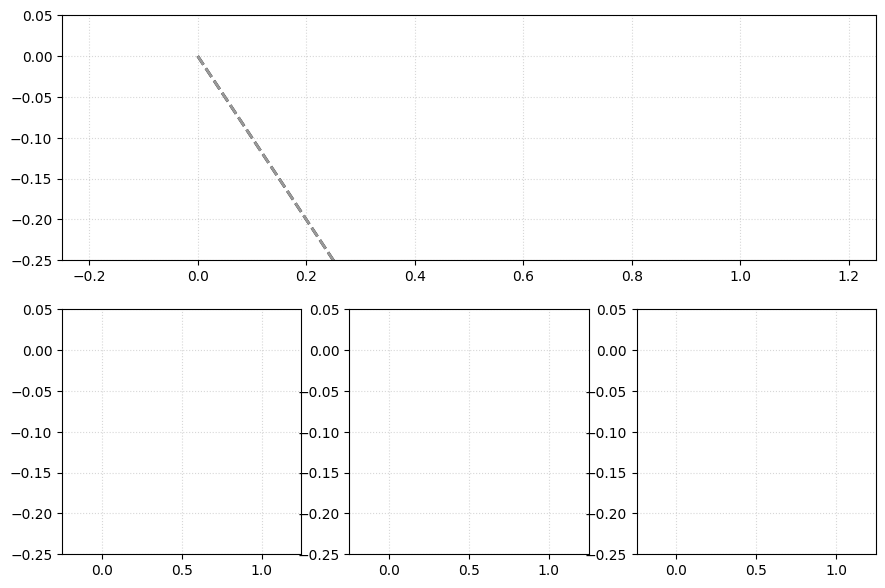

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# -----------------------------
# Choose mode: "frozen" (spiral) or "coupled" (full 3D projection)
# -----------------------------
MODE = "coupled"   # <- set to "coupled" to see the non-spiral projection

# -----------------------------
# Parameters
# -----------------------------
lam  = 1.0
m0   = 0.01
U0, V0, M0 = .99, -0.01, m0

# c values used in the paper
c_list  = [1.0, 2.0*(1.0 - m0), 3.0]     # {c < c_min, c = c_min, c > c_min}
labels  = [r"$c<c_{\min}$", r"$c=c_{\min}$", r"$c>c_{\min}$"]
colors  = ["tab:blue", "purple", "tab:orange"]

# plotting windows (apply to all axes)
U_lim = (-0.25, 1.25)
V_lim = (-0.25, 0.05)

# integration output (paper: τ = 0.01, final t = 100)
T_end  = 1000.0
dt     = 0.001
t_eval = np.arange(0.0, T_end + dt, dt)

# -----------------------------
# RHS: full (U,V,M) system
# -----------------------------
def rhs_3d(z, y, c):
    U, V, M = y
    M = np.clip(M, -5.0, 1.0 - 1e-9)
    dU = V
    dV = (1.0/(1.0 - M)) * (
            -c*V
            - (lam/c)*M*U*V
            - (lam**2 / c**2)*M*U**3
            - U*(1.0 - U - M)
         )
    dM = (lam/c)*M*U
    return [dU, dV, dM]

# -----------------------------
# RHS: planar (U,V) with M frozen at m0  -> this produces the spiral
# -----------------------------
def rhs_2d(z, y, c):
    U, V = y
    M = m0
    dU = V
    dV = (1.0/(1.0 - M)) * (
            -c*V
            - (lam/c)*M*U*V
            - (lam**2 / c**2)*M*U**3
            - U*(1.0 - U - M)
         )
    return [dU, dV]

# -----------------------------
# Linearisation slopes at (0,0) for M = m0 (for eigenvector lines)
# A = [[0,1],[-1, -c/(1-m0)]]; slopes are roots of l^2 + (c/(1-m0)) l + 1 = 0
# -----------------------------
def eig_slopes(c):
    a = c/(1.0 - m0)
    disc = a*a - 4.0
    if disc >= 0:
        l1 = 0.5*(-a + np.sqrt(disc))
        l2 = 0.5*(-a - np.sqrt(disc))
    else:
        l1 = l2 = -0.5*a        # real part for guidance in spiral case
    return float(l1), float(l2)

# -----------------------------
# Figure layout (top + 3 bottoms)
# -----------------------------
fig = plt.figure(figsize=(10.5, 7.0))
ax_top = plt.subplot2grid((2,3), (0,0), colspan=3)
axes   = [plt.subplot2grid((2,3), (1,i)) for i in range(3)]

# Draw eigenvectors once (for c=c_min) in top panel
c_mid = c_list[1]
l1_mid, l2_mid = eig_slopes(c_mid)
U_eig = np.array([0.0, 1.0])
ax_top.plot(U_eig, l1_mid*U_eig, ls='--', lw=2.0, color='k')
ax_top.plot(U_eig, l2_mid*U_eig, ls='--', lw=2.0, color='0.6')

for ax in [ax_top] + axes:
    ax.set_xlim(U_lim); ax.set_ylim(V_lim)
    ax.grid(True, ls=":", alpha=0.5)

# Integrate each case
for i, (c, lab, col) in enumerate(zip(c_list, labels, colors)):
    if MODE == "frozen":
        # planar integration with M ≡ m0  (spiral for c < c_min)
        sol = solve_ivp(rhs_2d, (0.0, T_end), [U0, V0],
                        args=(c,), t_eval=t_eval, rtol=1e-10, atol=1e-12, max_step=0.05)
        U, V = sol.y[0], sol.y[1]
    else:
        # full 3D, projected to (U,V)  (typically no spiral)
        sol = solve_ivp(rhs_3d, (0.0, T_end), [U0, V0, M0],
                        args=(c,), t_eval=t_eval, rtol=1e-10, atol=1e-12, max_step=0.05)
        U, V = sol.y[0], sol.y[1]

    # Top: overlay trajectories
    ax_top.plot(U, V, color=col, lw=2.0, label=lab)

    # Bottom per-case + its eigenvectors
    ax = axes[i]
    ax.plot(U, V, color=col, lw=2.2)
    l1, l2 = eig_slopes(c)
    ax.plot(U_eig, l1*U_eig, ls='--', lw=2.2, color='0.6')  # v2 (grey)
    ax.plot(U_eig, l2*U_eig, ls='--', lw=2.2, color='k')    # w3 (black)
    ax.set_xlabel(r"$U$")
    if i == 0:
        ax.set_ylabel(r"$V$")

# Cosmetics for top
ax_top.set_xlabel(r"$U$")
ax_top.set_ylabel(r"$V$")
ax_top.set_title(r"Phase plane for $U'=V$, $V'$; $m_0={:.2g}$, $\lambda={}$  ({})"
                 .format(m0, lam, MODE))
ax_top.legend(frameon=False, ncol=3, loc="lower right")

plt.tight_layout()
plt.show()